## Proof of concept of a simple cycle gan

In [1]:
import tensorflow as tf
import tensorflow.feature_column as fc 

import os
import sys
import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

#tf.enable_eager_execution()

# For output stability across multiple runs of the notebook
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print(sys.executable)

def shuffle_batch(X, batch_size):
    # Shuffle the indices
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    # Split the index array into the number of batches
    # Get the list of indexs per batch
    # and yield the values when asked
    for batch_idxs in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idxs]
        yield X_batch

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.__version__

/Users/Work/anaconda3/envs/condaflow/bin/python


'1.13.1'

In [2]:
# Funcs to generate data
def y(x,sign=1):
    return x*x

# Data ranging from x = -0.5 to 0.5
def sample_data(n=10000, scale=100):
    data1 = []
    data2 = []
    
    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = y(x[i])
        y2i = -yi
        data1.append([x[i], yi])
        data2.append([x[i], y2i])
        
    return np.array(data1), np.array(data2)

### Defining Constants

In [11]:
LAMBDA1 = 10
LAMBDA2 = 10
LR = 2e-4

In [12]:
#  def discriminator(X,hsize=[50,50], num_outputs=2, reuse=False):
    
#     with tf.variable_scope("D", reuse=reuse):
#         hidden1 = tf.layers.dense(X, hsize[0],name="d_hidden1",
#                                   activation=tf.nn.elu)
#         hidden2 = tf.layers.dense(hidden1, hsize[1],name="d_hidden2",
#                                   activation=tf.nn.elu)
#         logits = tf.layers.dense(hidden2, num_outputs, name = "d_logits")
    
#     return logits



def generator(X, name, hsize=[10,10], num_outputs=2, reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
        hidden1 = tf.layers.dense(X, hsize[0],name="g_hidden1",
                                  activation=tf.nn.elu)
        hidden2 = tf.layers.dense(hidden1, hsize[1],name="g_hidden2",
                                  activation=tf.nn.tanh)
        logits = tf.layers.dense(hidden2, num_outputs, name = "g_logits" )
    
    return logits

def discriminator(X, name, hsize=[10,10], num_outputs=2, reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
        hidden1 = tf.layers.dense(X, hsize[0],name="d_hidden1",
                                  activation=tf.nn.elu)
        hidden2 = tf.layers.dense(hidden1, hsize[1],name="d_hidden2",
                                  activation=tf.nn.elu)
        logits = tf.layers.dense(hidden2, num_outputs, name = "d_logits")
    
    return logits

# def cycle_consistency_loss(self, G, F, x, y):
#     """ cycle consistency loss (L1 norm)
#     """
#     forward_loss = tf.reduce_mean(tf.abs(F(G(x))-x))
#     backward_loss = tf.reduce_mean(tf.abs(G(F(y))-y))
#     loss = self.lambda1*forward_loss + self.lambda2*backward_loss
#     return loss

def cycle_consistency_loss(G_Fy, F_Gx, X, Y):
    """ cycle consistency loss (L1 norm)
    """
    lambda1 =10
    lambda2=10
    forward_loss = tf.reduce_mean(tf.abs(F_Gx-X))
    backward_loss = tf.reduce_mean(tf.abs(G_Fy-Y))
    loss = lambda1*forward_loss + lambda2*backward_loss
    return loss


# Returns the heuristic loss -> E[log D(G)] / 2
def generator_loss(D):
    return -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D, labels = tf.zeros_like(D)))/2

def discriminator_loss(D_real, D_fake):
    D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real, labels = tf.ones_like(D_real)))
    D_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake, labels = tf.zeros_like(D_fake)))
    return (D_real_loss + D_fake_loss)/2

#### Simulating Data

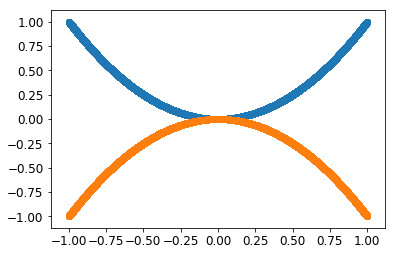

In [13]:
X1, X2 = sample_data(n=20000,scale=2)
train_data = np.concatenate([X1,X2],axis=1)
plt.scatter(X1[:,0], X1[:,1])
# plt.show()
plt.scatter(X2[:,0], X2[:,1])

In [14]:
reset_graph()

sess = tf.Session()

nDims = X1.shape[1]

X = tf.placeholder(tf.float32, shape=(None,nDims), name = "X")
Y = tf.placeholder(tf.float32, shape=(None, nDims), name="Y")

In [11]:
# Generating forward GAN = G: X -> Y

fakeY = generator(X,name="G")
D_Y = discriminator(Y, name="D_G")
D_G = discriminator(fakeY, name="D_G", reuse=True)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [15]:
# Generating backward GAN = F: Y -> X

fakeX = generator(Y,name="F")
D_X = discriminator(X, name="D_F")
D_F = discriminator(fakeX, name="D_F", reuse=True)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Calculating all losses

# Cycle consistency loss
G_Fy = generator(fakeY, name="G", reuse = True)
F_Gx = generator(fakeX, name="F", reuse = True)
cycle_loss = cycle_consistency_loss(G_Fy, F_Gx, X, Y)

# Forward GAN loss
G_loss = generator_loss(D_G) + cycle_loss
D_Y_loss = discriminator_loss(D_Y, D_G)

# Backward GAN loss
F_loss = generator_loss(D_F) + cycle_loss
D_X_loss = discriminator_loss(D_X, D_F)

NameError: name 'fakeY' is not defined

#### We will make separate optimizers for the 4 neural networks: 2 Generators, 2 Discriminators

In [116]:
# Setting up optimizers
learning_rate = 0.0001

g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="G")
dg_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="D_G")

f_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="F")
df_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="D_F")

adam = tf.train.AdamOptimizer()

trainer_G = adam.minimize(G_loss, var_list= g_vars)
trainer_DG = adam.minimize(D_Y_loss, var_list= dg_vars)

trainer_F = adam.minimize(F_loss, var_list= f_vars)
trainer_DF = adam.minimize(D_X_loss, var_list= df_vars)

In [117]:
sess.run(tf.global_variables_initializer())
batch_size = 100
for epoch in range(30):
  epoch_dLoss=0
  epoch_gLoss=0
  for i,batch in enumerate(shuffle_batch(train_data, batch_size)):
    # train
    X_batch = batch[:,:2]
    Y_batch = batch[:,2:]

    _, D_Y_loss_val, _ , D_X_loss_val = sess.run([trainer_DG, D_Y_loss, trainer_DF, D_X_loss],
                                            feed_dict={X: X_batch, Y: Y_batch})

    _, G_loss_val, _, F_loss_val = sess.run([trainer_G, G_loss, trainer_F, F_loss],
                                         feed_dict={X: X_batch, Y: Y_batch})

  print("Epoch {}: DYLoss:{:.4f}, DXLoss:{:.4f}, GLoss:{:.4f}, FLoss:{:.4f}".format(epoch, D_Y_loss_val, D_X_loss_val, G_loss_val, F_loss_val))

Epoch 0: DYLoss:0.6916, DXLoss:0.7052, GLoss:1.8084, FLoss:1.8335
Epoch 1: DYLoss:0.6094, DXLoss:0.6171, GLoss:0.1596, FLoss:0.1572
Epoch 2: DYLoss:0.5155, DXLoss:0.5733, GLoss:-0.0254, FLoss:-0.0350
Epoch 3: DYLoss:0.4333, DXLoss:0.6070, GLoss:-0.0827, FLoss:-0.1590
Epoch 4: DYLoss:0.4863, DXLoss:0.6487, GLoss:-0.1118, FLoss:-0.1848
Epoch 5: DYLoss:0.5830, DXLoss:0.6574, GLoss:-0.1794, FLoss:-0.2097
Epoch 6: DYLoss:0.7333, DXLoss:0.6564, GLoss:-0.2119, FLoss:-0.1739
Epoch 7: DYLoss:0.7254, DXLoss:0.6545, GLoss:-0.2066, FLoss:-0.1605
Epoch 8: DYLoss:0.7016, DXLoss:0.6656, GLoss:-0.2539, FLoss:-0.2233
Epoch 9: DYLoss:0.6985, DXLoss:0.6656, GLoss:-0.2734, FLoss:-0.2706
Epoch 10: DYLoss:0.6952, DXLoss:0.6620, GLoss:-0.2823, FLoss:-0.2670
Epoch 11: DYLoss:0.6965, DXLoss:0.6745, GLoss:-0.2934, FLoss:-0.2819
Epoch 12: DYLoss:0.6942, DXLoss:0.6672, GLoss:-0.2842, FLoss:-0.2895
Epoch 13: DYLoss:0.6938, DXLoss:0.6675, GLoss:-0.2924, FLoss:-0.2907
Epoch 14: DYLoss:0.6924, DXLoss:0.6632, GLoss:-0

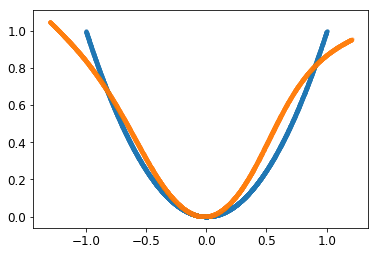

In [118]:
generatedX = generator(Y,name="F",reuse=True)
temp = sess.run([generatedX], feed_dict={Y:X2})

genX = temp[0]
plt.scatter(X1[:,0], X1[:,1],marker=".",alpha=0.1)
plt.scatter(genX[:,0], genX[:,1],marker=".",alpha=0.1)

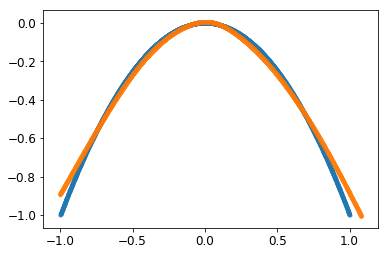

In [120]:
generatedY = generator(X,name="G",reuse=True)
temp = sess.run([generatedY], feed_dict={X:X1})

genY = temp[0]
plt.scatter(X2[:,0], X2[:,1],marker=".",alpha=0.1)
plt.scatter(genY[:,0], genY[:,1],marker=".",alpha=0.1)

In [47]:
sess.run([trainer_DG, D_Y_loss], feed_dict={X: X_batch, Y: Y_batch})

[None, 151.59767]

In [17]:
sess.run([trainer_DG, D_Y_loss], feed_dict={X: X_batch, Y: Y_batch})

NameError: name 'trainer_DG' is not defined

In [20]:
from generator import Generator

GF = Generator("GF_pls")

In [23]:
gf = GF(X)
sess.run([gf], feed_dict ={X:X1})

FailedPreconditionError: Attempting to use uninitialized value GF_pls/g_logits/bias
	 [[node GF_pls/g_logits/bias/read (defined at /Users/Work/Developer/roboGAN/generator.py:24) ]]

Caused by op 'GF_pls/g_logits/bias/read', defined at:
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-cabec38bc917>", line 1, in <module>
    GF(X)
  File "/Users/Work/Developer/roboGAN/generator.py", line 24, in __call__
    logits = tf.layers.dense(hidden2, self.output_dim, name = "g_logits" )
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/layers/core.py", line 188, in dense
    return layer.apply(inputs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1227, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 530, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 538, in __call__
    self._maybe_build(inputs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1603, in _maybe_build
    self.build(input_shapes)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py", line 958, in build
    trainable=True)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 435, in add_weight
    getter=vs.get_variable)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 349, in add_weight
    aggregation=aggregation)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 607, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1479, in get_variable
    aggregation=aggregation)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1220, in get_variable
    aggregation=aggregation)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 547, in get_variable
    aggregation=aggregation)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 499, in _true_getter
    aggregation=aggregation)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 911, in _get_single_variable
    aggregation=aggregation)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3890, in identity
    "Identity", input=input, name=name)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Users/Work/anaconda3/envs/condaflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value GF_pls/g_logits/bias
	 [[node GF_pls/g_logits/bias/read (defined at /Users/Work/Developer/roboGAN/generator.py:24) ]]
